# GRF - examples 1D

Generate gaussian random fields (GRF) using fast Fourier transform (FFT).

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import package 'geone'
import geone as gn

### Remark
The matplotlib figures can be visualized in *interactive* mode:
- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Define a covariance model in 1D: class `geone.covModel.covModel1D`

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

In [2]:
cov_model = gn.covModel.CovModel1D(elem=[
    ('gaussian', {'w':5., 'r':100}), # elementary contribution
    ('nugget', {'w':1.})             # elementary contribution
    ], name='model-1D example')

In [3]:
cov_model

Covariance model 1D: (Name = model-1D example)
   2 elementary contribution(s)
   Elementary contribution 0: type : gaussian
      parameters:  w = 5.0,  r = 100
   Elementary contribution 1: type : nugget
      parameters:  w = 1.0

### Plot the covariance / variogram function of the model

Plot the covariance function.

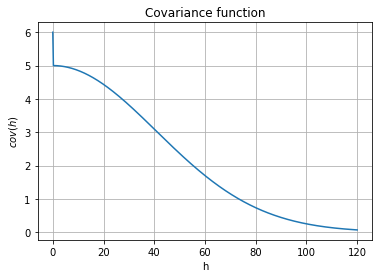

In [4]:
cov_model.plot_model()
plt.title('Covariance function')
plt.show()

Plot the variogram function.

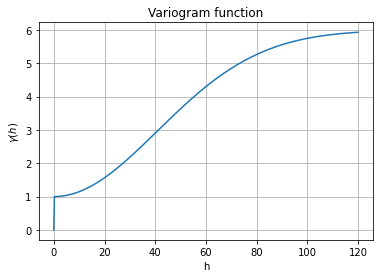

In [5]:
cov_model.plot_model(vario=True)
plt.title('Variogram function')
plt.show()

Plot the covariance and variogram functions in a same figure.

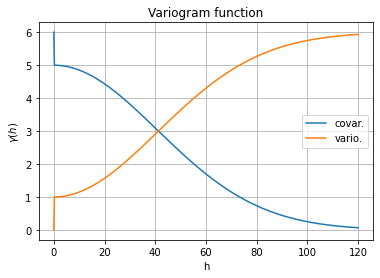

In [6]:
cov_model.plot_model(label='covar.')
cov_model.plot_model(vario=True, label='vario.')
plt.legend()
plt.title('Variogram function')
plt.show()

### Get the sill and range

In [7]:
w = cov_model.sill()
r = cov_model.r()
print('Sill = {}'.format(w))
print('Range = {}'.format(r))

Sill = 6.0
Range = 100


## Simulation of GRFs - 1D
Define the simulation grid.

In [8]:
nx = 1000 # number of cells
dx = 0.5  # cell unit
ox = 0.0  # origin

### Remark
As the generation of GRFs is based on FFT, periodic fields are generated. Hence, an extended simulation grid is used and then cropped after the simulation. The extension should be large enough in order to avoid wrong correlations, i.e. correlations across opposite borders of the grid, or correlations between two nodes regarding both distances between them (with respect to the periodic grid).

An appropriate extension is automatically computed by the function `geone.grf.grf1D` based on the covariance model class passed as first argument. However, the minimal extension can be given explicitly with the keyword argument `extensionMin`.

Note that a covariance function can be passed as first argument (in the example below, the function `cov_model.func()` instead of the class `cov_model`). In this situation, an appropriate minimal extension can be computed by the function `extension_min` (i.e. `extension_min(cov_model.r(), nx, dx)`), and then passed to the GRF simulator `geone.grf.grf1D` via the keyword argument `extensionMin`.

#### Notes
When passing the covariance model class as first argument, the extension is computed based on the range of the covariance. If the results show artefacts or unexpected features (this can happen when using Gaussian covariance model), one may try to fix the problem by increasing the extension. To do so, a factor (greather than one) can be specified via the keyword argument `rangeFactorForExtensionMin`: the range will be multiplied by this factor before computing the extension.

### Unconditional simulations
Set the number of realizations, the seed and launch the (unconditional) simulations.

*Remark:* the keyword argument `printInfo` (`True` by default) can be set to `False` to not display information when running.

In [9]:
nreal = 10000
np.random.seed(123)
# sim1Da = gn.grf.grf1D(cov_model, nx, dx, ox,nreal=nreal)
sim1Da = gn.grf.grf1D(cov_model, nx, dx, ox,nreal=nreal, printInfo=False)

The result is a 2d array of size `nreal` by `nx`:

In [10]:
sim1Da.shape

(10000, 1000)

Compute the mean and the standard deviation over the realizations (pixel-wise).

In [11]:
sim1Da_mean = np.mean(sim1Da, axis=0)
sim1Da_std = np.std(sim1Da, axis=0)

Plot the first realizations, the mean, and the mean +/- standard deviation.

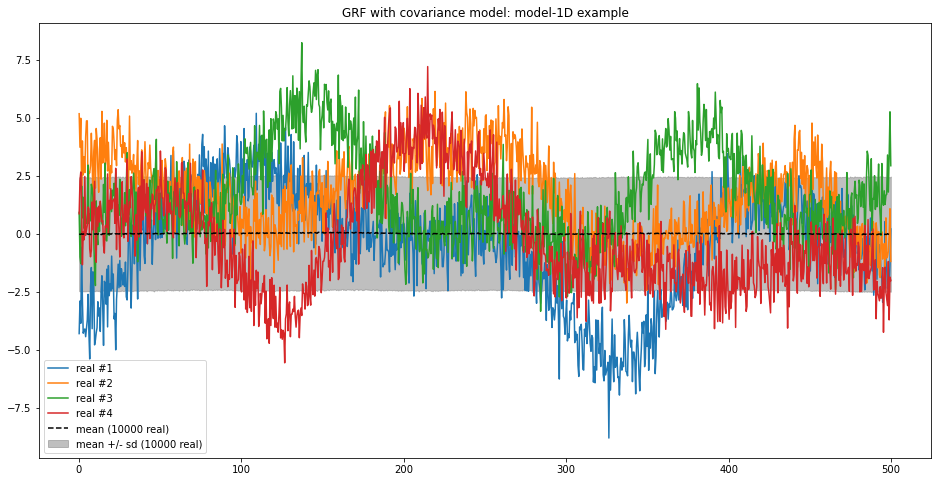

In [12]:
xg = ox + dx*(0.5+np.arange(nx)) # center of grid cells

plt.figure(figsize=(16,8))

for i in range(4):
    plt.plot(xg, sim1Da[i], label='real #{}'.format(i+1))

plt.plot(xg, sim1Da_mean, c='black', ls='dashed', label='mean ({} real)'.format(nreal))
plt.fill_between(xg, sim1Da_mean - sim1Da_std, sim1Da_mean + sim1Da_std, 
                 color='gray', alpha=.5, label='mean +/- sd ({} real)'.format(nreal))
plt.legend()
plt.title('GRF with covariance model: {}'.format(cov_model.name))
plt.show()

### Conditional simulations
Define hard data. Note that the conditioning values will be attached to the grid cells containing the corresponding conditioning locations.

In [13]:
x = [10.1, 50.7, 238.5, 384.3] # locations (real coordinates)
v = [-3.2,  1.2,   4.7,  -2.0] # values

Launch the simulations and plot.

In [14]:
nreal = 10000
np.random.seed(123)
sim1Db = gn.grf.grf1D(cov_model, nx, dx, ox, x=x, v=v, nreal=nreal, printInfo=False)
sim1Db_mean = np.mean(sim1Db, axis=0)
sim1Db_std = np.std(sim1Db, axis=0)

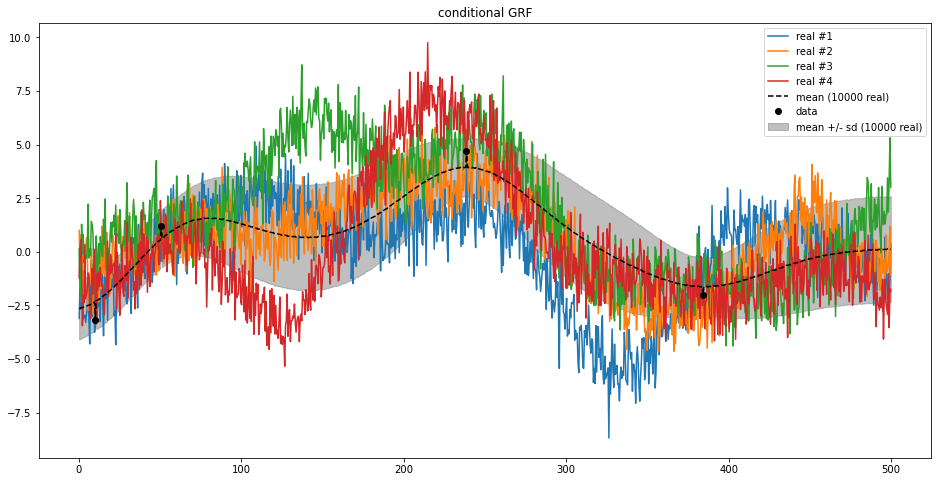

In [15]:
# Plot the first realizations, the mean and the mean +/- standard deviation
plt.figure(figsize=(16,8))

for i in range(4):
    plt.plot(xg, sim1Db[i], label='real #{}'.format(i+1))

plt.plot(xg, sim1Db_mean, c='black', ls='dashed', label='mean ({} real)'.format(nreal))
plt.fill_between(xg, sim1Db_mean - sim1Db_std, sim1Db_mean + sim1Db_std, 
                 color='gray', alpha=.5, label='mean +/- sd ({} real)'.format(nreal))
plt.plot(x, v, 'o', c='k', label='data') # add conditioning points
plt.legend()
plt.title('conditional GRF')
plt.show()

### Kriging
Compute (simple) kriging estimates and standard deviation.

In [16]:
krig1Db, krig1Db_std = gn.grf.krige1D(x, v, cov_model, nx, dx, ox)

KRIGE1D: Computing circulant embedding...
KRIGE1D: Embedding dimension: 2048
KRIGE1D: Computing FFT of circulant matrix...
KRIGE1D: Computing covariance matrix (rAA) for conditioning locations...
KRIGE1D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
KRIGE1D: Computing rBA * rAA^(-1)...
KRIGE1D: computing kriging estimates...
KRIGE1D: computing kriging standard deviation ...


Plot the first realizations of the previous simulation and the kriging estimates and standard deviation.

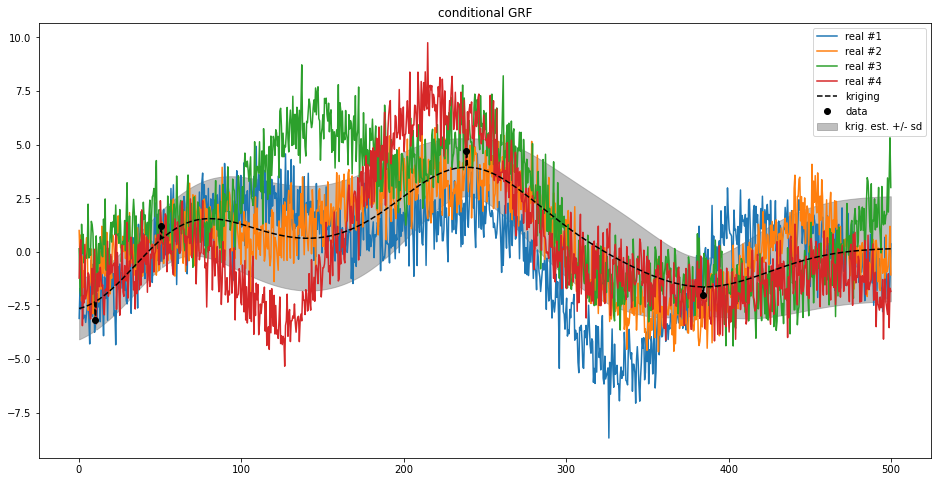

In [17]:
plt.figure(figsize=(16,8))

for i in range(4):
    plt.plot(xg, sim1Db[i], label='real #{}'.format(i+1))

plt.plot(xg, krig1Db, c='black', ls='dashed', label='kriging')
plt.fill_between(xg, krig1Db - krig1Db_std, krig1Db + krig1Db_std, 
                 color='gray', alpha=.5, label='krig. est. +/- sd')
plt.plot(x, v, 'o', c='k', label='data') # add conditioning points
plt.legend()
plt.title('conditional GRF')
plt.show()

## Simulations with imposed mean and/or variance
Mean and variance in the simulation grid can be specified, they can be stationary (constant) or non-stationary. 
By default, the mean is set to the mean of data values (or zero if no conditioning data) (constant) and the variance is given by the sill of the variogram model (constant).

### Simulations with constant mean and variance
Set mean to $3.0$ and variance to the double of the covariance model sill.

In [18]:
nreal = 10000
np.random.seed(123)
sim1Dc = gn.grf.grf1D(cov_model, nx, dx, ox, x=x, v=v, 
                      mean=3., var=2*cov_model.sill(), nreal=nreal, printInfo=False)
sim1Dc_mean = np.mean(sim1Dc, axis=0)
sim1Dc_std = np.std(sim1Dc, axis=0)

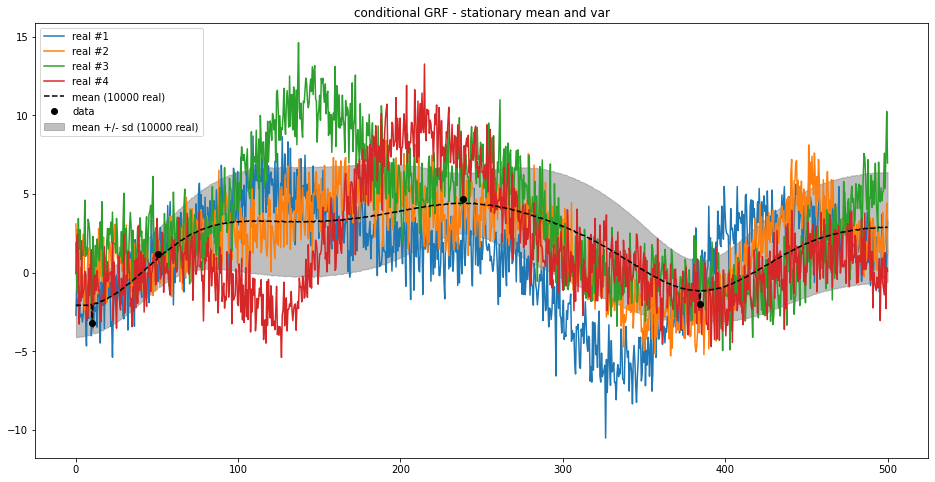

In [19]:
# Plot the first realizations, the mean and the mean +/- standard deviation
plt.figure(figsize=(16,8))

for i in range(4):
    plt.plot(xg, sim1Dc[i], label='real #{}'.format(i+1))

plt.plot(xg, sim1Dc_mean, c='black', ls='dashed', label='mean ({} real)'.format(nreal))
plt.fill_between(xg, sim1Dc_mean - sim1Dc_std, sim1Dc_mean + sim1Dc_std, 
                 color='gray', alpha=.5, label='mean +/- sd ({} real)'.format(nreal))
plt.plot(x, v, 'o', c='k', label='data') # add conditioning points
plt.legend()
plt.title('conditional GRF - stationary mean and var')
plt.show()

In [20]:
krig1Dc, krig1Dc_std = gn.grf.krige1D(x, v, cov_model, nx, dx, ox, mean=3., var=2*cov_model.sill())

KRIGE1D: Computing circulant embedding...
KRIGE1D: Embedding dimension: 2048
KRIGE1D: Computing FFT of circulant matrix...
KRIGE1D: Computing covariance matrix (rAA) for conditioning locations...
KRIGE1D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
KRIGE1D: Computing rBA * rAA^(-1)...
KRIGE1D: computing kriging estimates...
KRIGE1D: computing kriging standard deviation ...


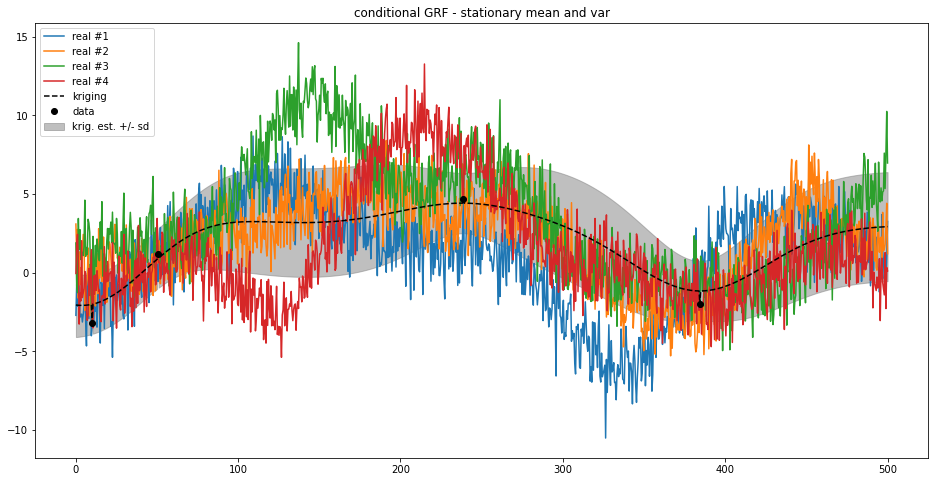

In [21]:
# Plot the first realizations of the previous simulation and the result of kriging.
plt.figure(figsize=(16,8))

for i in range(4):
    plt.plot(xg, sim1Dc[i], label='real #{}'.format(i+1))

plt.plot(xg, krig1Dc, c='black', ls='dashed', label='kriging')
plt.fill_between(xg, krig1Dc - krig1Dc_std, krig1Dc + krig1Dc_std, 
                 color='gray', alpha=.5, label='krig. est. +/- sd')
plt.plot(x, v, 'o', c='k', label='data') # add conditioning points
plt.legend()
plt.title('conditional GRF - stationary mean and var')
plt.show()

### Simulations with non-stationary mean and variance
Set the mean varying linearly from $-10.0$ (at the left border) to $+10.0$ (at the right border), and the variance
from $0.1$ to $4.0$.

In [22]:
# Set mean and variance
mean = np.linspace(-10, 10, nx)
var = np.linspace(0.1, 4, nx)*w

# Simulation
nreal = 10000
np.random.seed(123)
sim1Dd = gn.grf.grf1D(cov_model, nx, dx, ox, x=x, v=v, mean=mean, var=var, nreal=nreal, printInfo=False)
sim1Dd_mean = np.mean(sim1Dd, axis=0)
sim1Dd_std = np.std(sim1Dd, axis=0)

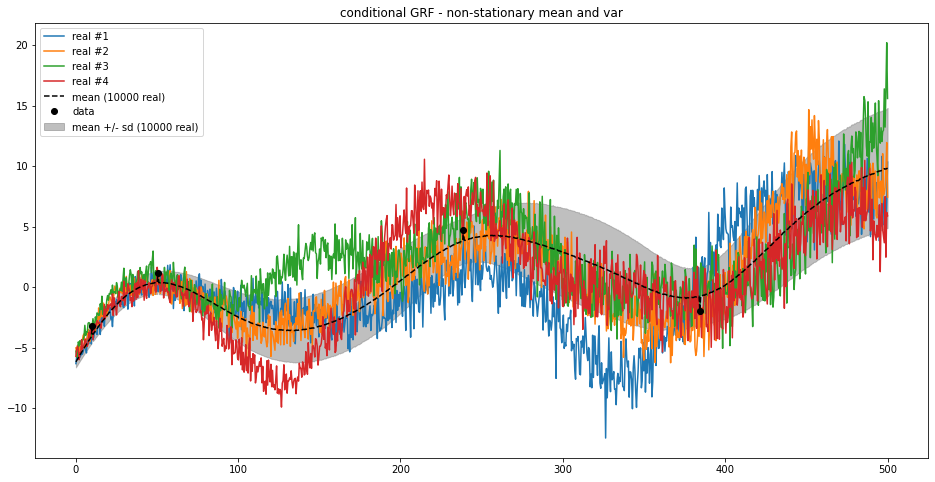

In [23]:
# Plot the first realizations, the mean and the mean +/- standard deviation
plt.figure(figsize=(16,8))

for i in range(4):
    plt.plot(xg, sim1Dd[i], label='real #{}'.format(i+1))

plt.plot(xg, sim1Dd_mean, c='black', ls='dashed', label='mean ({} real)'.format(nreal))
plt.fill_between(xg, sim1Dd_mean - sim1Dd_std, sim1Dd_mean + sim1Dd_std, 
                 color='gray', alpha=.5, label='mean +/- sd ({} real)'.format(nreal))
plt.plot(x, v, 'o', c='k', label='data') # add conditioning points
plt.legend()
plt.title('conditional GRF - non-stationary mean and var')
plt.show()

In [24]:
krig1Dd, krig1Dd_std = gn.grf.krige1D(x, v, cov_model, nx, dx, ox, mean=mean, var=var)

KRIGE1D: Computing circulant embedding...
KRIGE1D: Embedding dimension: 2048
KRIGE1D: Computing FFT of circulant matrix...
KRIGE1D: Computing covariance matrix (rAA) for conditioning locations...
KRIGE1D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
KRIGE1D: Computing rBA * rAA^(-1)...
KRIGE1D: computing kriging estimates...
KRIGE1D: computing kriging standard deviation ...


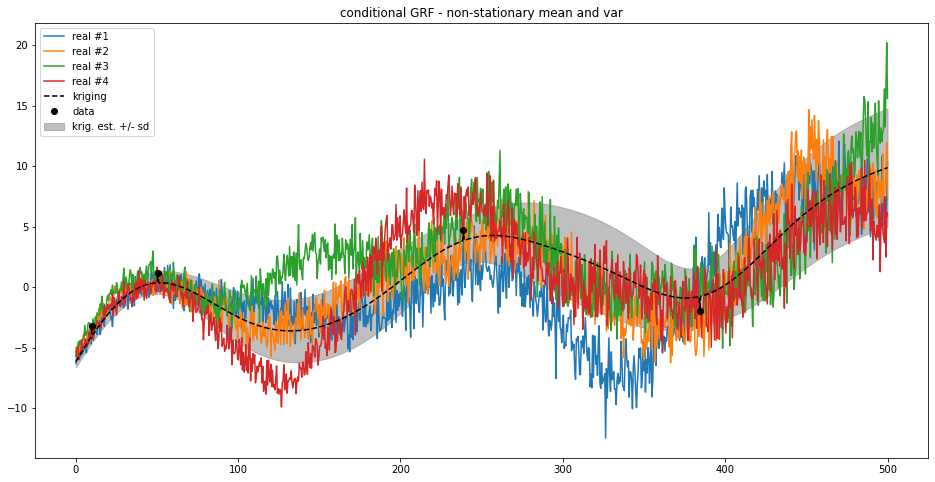

In [25]:
# Plot the first realizations of the previous simulation and the result of kriging.
plt.figure(figsize=(16,8))

for i in range(4):
    plt.plot(xg, sim1Dd[i], label='real #{}'.format(i+1))

plt.plot(xg, krig1Dd, c='black', ls='dashed', label='kriging')
plt.fill_between(xg, krig1Dd - krig1Dd_std, krig1Dd + krig1Dd_std, 
                 color='gray', alpha=.5, label='krig. est. +/- sd')
plt.plot(x, v, 'o', c='k', label='data') # add conditioning points
plt.legend()
plt.title('conditional GRF - non-stationary mean and var')
plt.show()

## Comparison of mean and standard deviation of all realizations with kriging results

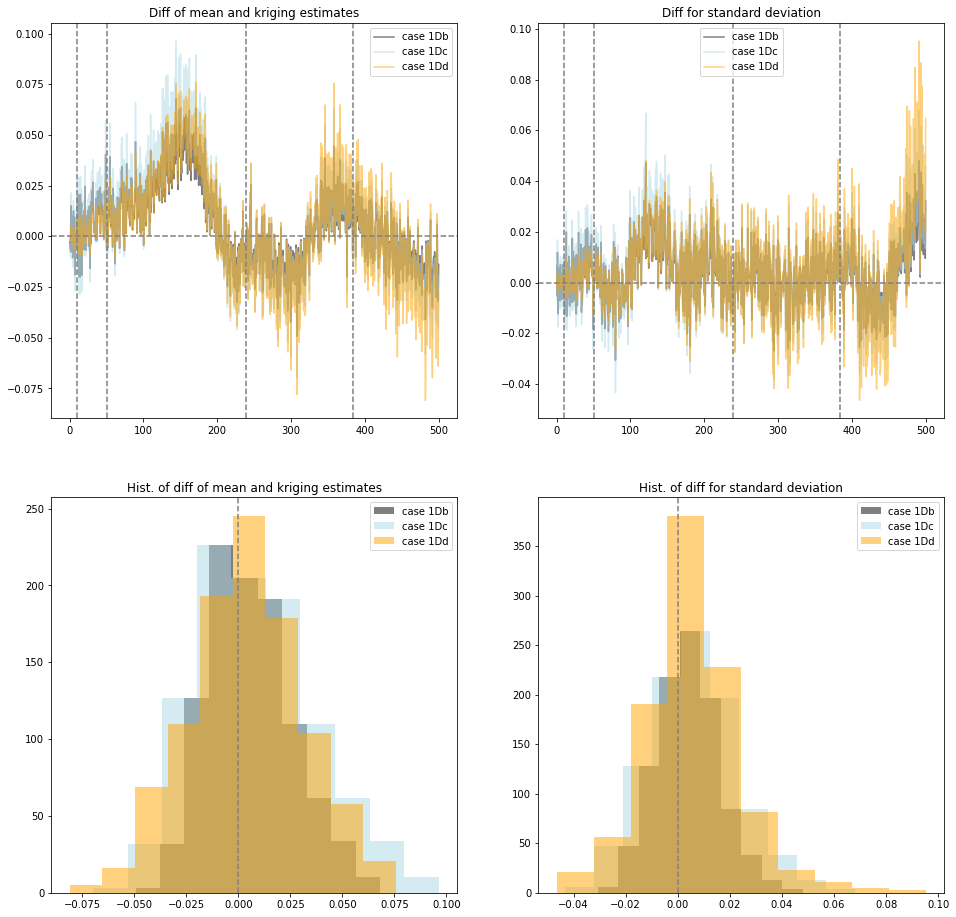

In [26]:
plt.subplots(2, 2, figsize=(16,16)) # 2 x 2 sub-plots

plt.subplot(2, 2, 1) # first sub-plot
plt.plot(xg, sim1Db_mean - krig1Db, c='black', alpha=0.5, label='case 1Db')
plt.plot(xg, sim1Dc_mean - krig1Dc, c='lightblue', alpha=0.5, label='case 1Dc')
plt.plot(xg, sim1Dd_mean - krig1Dd, c='orange', alpha=0.5, label='case 1Dd')
for xx in x:
    plt.axvline(x=xx, c='gray', ls='dashed') # vertical lines at conditioning points
plt.axhline(y=0, c='gray', ls='dashed') # horizontal line at zero
plt.legend()
plt.title('Diff of mean and kriging estimates')

plt.subplot(2, 2, 2) # second sub-plot
plt.plot(xg, sim1Db_std - krig1Db_std, c='black', alpha=0.5, label='case 1Db')
plt.plot(xg, sim1Dc_std - krig1Dc_std, c='lightblue', alpha=0.5, label='case 1Dc')
plt.plot(xg, sim1Dd_std - krig1Dd_std, c='orange', alpha=0.5, label='case 1Dd')
for xx in x:
    plt.axvline(x=xx, c='gray', ls='dashed') # vertical lines at conditioning points
plt.axhline(y=0, c='gray', ls='dashed') # horizontal line at zero
plt.legend()
plt.title('Diff for standard deviation')

plt.subplot(2, 2, 3) # third sub-plot
plt.hist(sim1Db_mean - krig1Db, color='black', alpha=0.5, label='case 1Db')
plt.hist(sim1Dc_mean - krig1Dc, color='lightblue', alpha=0.5, label='case 1Dc')
plt.hist(sim1Dd_mean - krig1Dd, color='orange', alpha=0.5, label='case 1Dd')
plt.axvline(x=0, c='gray', ls='dashed') # vertical line at zero
plt.legend()
plt.title('Hist. of diff of mean and kriging estimates')

plt.subplot(2, 2, 4) # fourth sub-plot
plt.hist(sim1Db_std - krig1Db_std, color='black', alpha=0.5, label='case 1Db')
plt.hist(sim1Dc_std - krig1Dc_std, color='lightblue', alpha=0.5, label='case 1Dc')
plt.hist(sim1Dd_std - krig1Dd_std, color='orange', alpha=0.5, label='case 1Dd')
plt.axvline(x=0, c='gray', ls='dashed') # vertical line at zero
plt.legend()
plt.title('Hist. of diff for standard deviation')
plt.show()